In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/code/data/train/subtask_1/en/')
#os.chdir('/content/drive/My Drive/Colab Notebooks/code/data/test/subtask_1/en/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import re
import openai
import matplotlib.pyplot as plt

In [ ]:
from google.colab import userdata
api_key = userdata.get('api-key')

In [ ]:
train = pd.read_csv("train.tsv", delimiter="\t")
train.drop(columns = ['Unnamed: 0'], inplace = True)
train = train[train['prompt'] != 'NO-PROMPT']
train = train[train['model'] == 'A']

tweet_prompts = train[train['domain'] == 'tweets'].sample(n=333)['prompt']
legal_prompts = train[train['domain'] == 'legal'].sample(n=333)['prompt']
wiki_prompts = train[train['domain'] == 'wiki'].sample(n=334)['prompt']
train

,id,prompt,text,label,model,domain
6,200,The following shall be entered in box 4 of cer...,"2., paragraph 3., amend as follows: 3. In the ...",generated,A,legal
9,22678,Take the chicken breasts out of their packagin...,"Once you have done this, place them on top of ...",generated,A,wiki
27,23226,"Initially, if your dog is capable of coughing,...","If not, then you will need to take it to a vet...",generated,A,wiki
29,251,Article 46. Repeal.,The provisions of this article shall be repeal...,generated,A,legal
32,22924,"Until fairly recently, modern science didn’t h...",Yet we now know that chronic stress impacts al...,generated,A,wiki
...,...,...,...,...,...,...
33810,11016,@JanOlePeek lol Which music? And,@JanOlePeek lol Which music? And when was the ...,generated,A,tweets
33819,11394,@msilve Bahahaha how many times,@msilve Bahahaha how many times have you heard...,generated,A,tweets
33824,189,(6) The measures provided for in this Regulati...,In order to comply with the requirements set o...,generated,A,legal
33836,769,An annual report on the operation of Tempus II...,It may contain recommendations concerning furt...,generated,A,legal


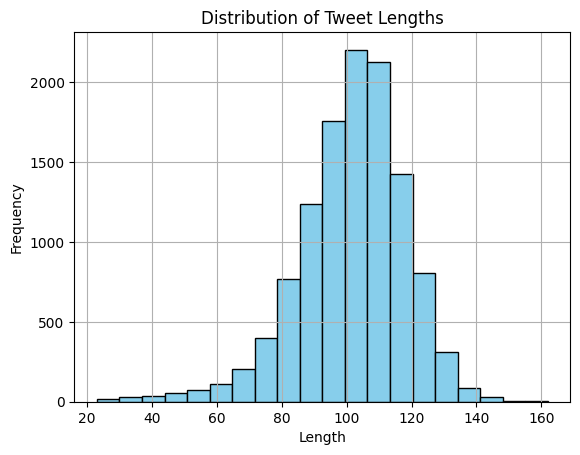

In [ ]:
tweet_texts = train[train['domain'] == 'tweets']['text']

# Calculate the lengths of the tweets
tweet_lengths = tweet_texts.str.len()

# Create a histogram
plt.hist(tweet_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

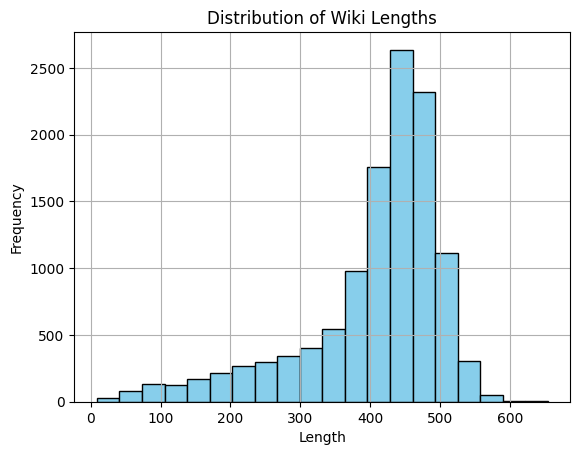

In [ ]:
wiki_texts = train[train['domain'] == 'wiki']['text']

# Calculate the lengths of the wiki
wiki_lengths = wiki_texts.str.len()

# Create a histogram
plt.hist(wiki_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Wiki Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


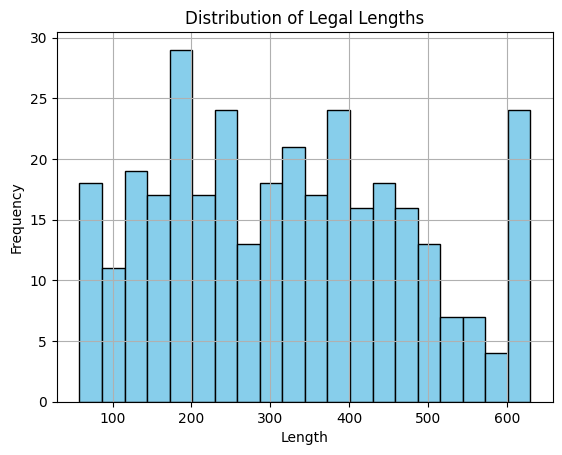

In [ ]:
legal_texts = train[train['domain'] == 'legal']['text']

# Calculate the lengths of the legal texts
legal_lengths = tweet_texts.str.len()

# Create a histogram
plt.hist(legal_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Legal Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Create prompts file

In [ ]:
tweet_prompts = pd.DataFrame(tweet_prompts)
legal_prompts = pd.DataFrame(legal_prompts)
wiki_prompts = pd.DataFrame(wiki_prompts)

tweet_prompts['domain'] = 'tweets'
legal_prompts['domain'] = 'legal'
wiki_prompts['domain'] = 'wiki'
combined_prompts = pd.concat([tweet_prompts, legal_prompts, wiki_prompts], ignore_index=True)


combined_prompts.to_csv("GPT_prompts.csv", index=False)

## Truncate the texts, if they are longer than 630 char.

In [ ]:
df = pd.read_csv("gpt.csv")
df['text'] = df['text'].apply(lambda x: x[:630] if len(x) > 630 else x)
df.to_csv("gpt.csv", index=False)
df

,prompt,text,label,model,domain
0,this tweet is for josie!,"this tweet is for josie! Hey Josie, just wante...",generated,gpt-3.5-turbo,tweets
1,@claudia10 yea i read your,@claudia10 yea i read your @claudia10 yea I re...,generated,gpt-3.5-turbo,tweets
2,Proud of myself and saved,Proud of myself and saved That's great to hear...,generated,gpt-3.5-turbo,tweets
3,@DamiRadke nice! i wanna get,@DamiRadke nice! i wanna get Great to hear tha...,generated,gpt-3.5-turbo,tweets
4,Has some one built a,Has some one built a Has someone built a bette...,generated,gpt-3.5-turbo,tweets
...,...,...,...,...,...
996,You can use a dull knife to gently scrape the ...,"To remove tar from fabric, you can try using a...",generated,gpt-3.5-turbo,wiki
997,Clean your enamel before and after every use t...,Cleaning your enamel before and after each use...,generated,gpt-3.5-turbo,wiki
998,"If you want to avoid being bullied, you have t...",Avoiding bullying behavior is an important asp...,generated,gpt-3.5-turbo,wiki
999,Breathe in and out using your diaphragm (your ...,"Belly breathing, also known as diaphragmatic b...",generated,gpt-3.5-turbo,wiki


# Code for generating the texts using prompts.

In [ ]:
import openai
import pandas as pd

def create_texts(prompt_df, start_index, end_index, output, api_key):
    openai.api_key = api_key

    results = []

    for index, row in prompt_df.iloc[start_index:end_index].iterrows():
        prompt = row['prompt']
        domain = row['domain']
        length = len(prompt)
        gen_length_tweets = random.randint(480,500) # change the length parameter

        completion = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": f"Generating text for domain: {domain}"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=gen_length_tweets,
            stop=None
        )

        # Extracting the generated text
        generated_text = completion.choices[0].message.content

        # When domain is tweets, then we include the prompt as prefix
        if domain == 'tweets':
            text = prompt + " " + generated_text.strip()
        else:
            text = generated_text.strip()

        results.append({
            'prompt': prompt,
            'text': text,
            'label': "generated",
            'model': "gpt-3.5-turbo",
            'domain': domain
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save the results to the output file
    with open(output, 'a') as f:
      results_df.to_csv(f, header=f.tell()==0, index=False, mode='a')

In [ ]:
prompts = pd.read_csv("GPT_prompts.csv")

In [ ]:
# Example usage:
# create_texts(prompt_df, start_index, end_index, output, api_key)